# Configuring libraries & utilities

In [2]:
# Import required libraries
import os
import json
import math

from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from xgboost import XGBClassifier

# Upgrade scikit-learn
!pip install --upgrade scikit-learn

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, make_scorer
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
import pickle as pkl

# Try to import the custom module
try:
    import flash as fz
except ImportError:
    # Install the module if not present
    !pip install git+https://github.com/Althaf9900/flash.git    # Feel free to contribute to our custom module :)
    import flash as fz

  Cloning https://github.com/Althaf9900/flash.git to /tmp/pip-req-build-0dvefc6e
  Running command git clone --filter=blob:none --quiet https://github.com/Althaf9900/flash.git /tmp/pip-req-build-0dvefc6e
  Resolved https://github.com/Althaf9900/flash.git to commit addbcae25978c18a4335b83b97ebfb93b47d93f5
  Preparing metadata (setup.py) ... done
  Created wheel for flash: filename=flash-0.1-py3-none-any.whl size=2653 sha256=e21387cf4b5eeb2414293428e44d0a181a7313502974e3c4cc5df915a9b1c4ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-npcsz4rw/wheels/8a/54/00/d5029f7da28924f1e3b16dff3c68cf81f2129c674fe195f750
Successfully built flash


In [3]:
# Mount Google Drive if it's not already mounted
mount_point = "/content/drive"

if not os.path.ismount(mount_point):
    print("Mounting Google Drive...")
    drive.mount(mount_point)
else:
    print("Google Drive is already mounted.")

%cd /content/drive/MyDrive/Projects/loan-sanction-prediction

Mounting Google Drive...
Mounted at /content/drive
/content/drive/MyDrive/Projects/loan-sanction-prediction



# Initial data assessment & preparation


In [4]:
# Loading the dataset
df_copy = pd.read_csv('loan_sanction_train.csv')
df = df_copy

In [5]:
# Understanding structure of the dataset
df.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
47,LP001144,Male,Yes,0,Graduate,No,5821,0.0,144.0,360.0,1.0,Urban,Y
354,LP002143,Female,Yes,0,Graduate,No,2423,505.0,130.0,360.0,1.0,Semiurban,Y
523,LP002693,Male,Yes,2,Graduate,Yes,7948,7166.0,480.0,360.0,1.0,Rural,Y
181,LP001634,Male,No,0,Graduate,No,1916,5063.0,67.0,360.0,NaN,Rural,N
383,LP002234,Male,No,0,Graduate,Yes,7167,0.0,128.0,360.0,1.0,Urban,Y


In [6]:
# Checking whether Loan_ID contains duplicate IDs
df['Loan_ID'].duplicated().sum()

0

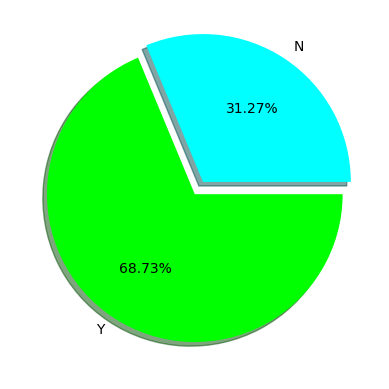

In [7]:
# Checking whether the dataset is imbalanced or not
plt.pie(df['Loan_Status'].value_counts(), labels = df['Loan_Status'].unique(), autopct='%0.2f%%',
        shadow=True, explode=(0, 0.1), counterclock=False, colors=['lime', 'cyan'])
plt.show()

In [8]:
# Columns of the dataset
print(df.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [9]:
# Getting some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Dropping useless features
df.drop('Loan_ID', axis=1, inplace=True)

In [11]:
# Extracting numerical features & categorical features from the dataset using a custom made module
num_cols = fz.get_num_col(df)
cat_cols = fz.get_cat_col(df, ignore_cols=['Loan_Status'])

# Number of categorical features
n_cat_cols = len(cat_cols)
n_num_cols = len(num_cols)


print(num_cols)
print(cat_cols)

print(f'Number of numerical features: {n_num_cols}')
print(f'Number of categorical features: {n_cat_cols}')

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
Number of numerical features: 3
Number of categorical features: 8



# EDA (Before data cleaning)



## Outlier analysis on numerical features


In [12]:
# Statistical measures
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0


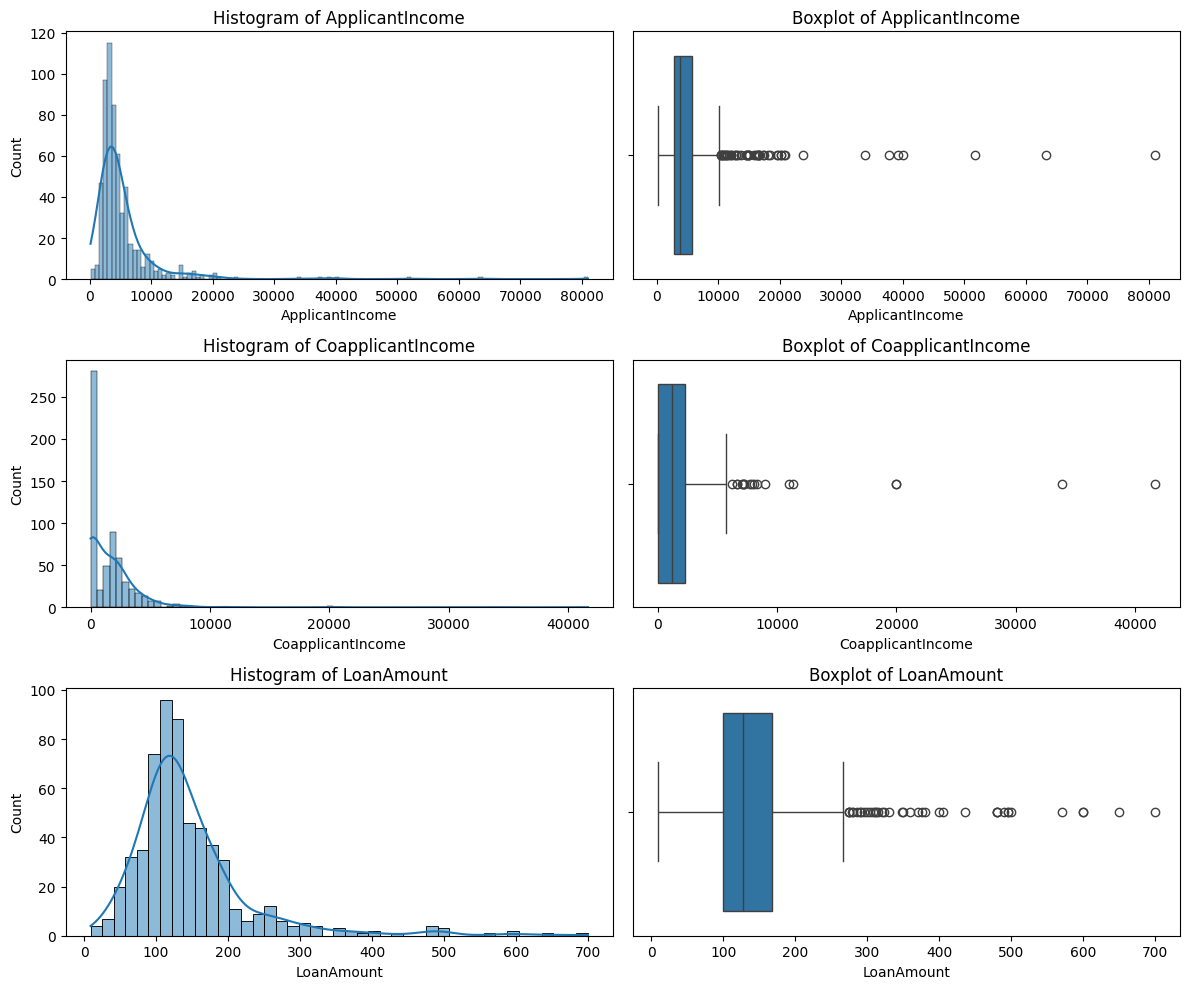

In [13]:
# Histogram & Box-plot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 10))

# Plotting histograms and boxplots
for i, col in enumerate(num_cols):
    # Histogram
    sns.histplot(df[col], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Boxplot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# Initialize a list to store features with outliers
ftrs_with_outliers = []

# Iterate through each numerical features to calculate IQR and identify outliers
for feature in df[num_cols].columns:
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check if the feature contains any outliers
    if ((df[feature] < lower_bound) | (df[feature] > upper_bound)).any():
        ftrs_with_outliers.append(feature)

print("Features with outliers:", ftrs_with_outliers)

Features with outliers: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [15]:
# Applicant income
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['ApplicantIncome'] < lower_bound) | (df['ApplicantIncome'] > upper_bound)]['ApplicantIncome'].sort_values()

,ApplicantIncome
119,10408
438,10416
128,10513
67,10750
483,10833
199,11000
271,11146
533,11250
106,11417
54,11500


In [16]:
# Co-applicant income
Q1 = df['CoapplicantIncome'].quantile(0.25)
Q3 = df['CoapplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['CoapplicantIncome'] < lower_bound) | (df['CoapplicantIncome'] > upper_bound)]['CoapplicantIncome'].sort_values()

,CoapplicantIncome
349,6250.0
513,6666.0
506,6667.0
253,7101.0
523,7166.0
38,7210.0
180,7250.0
135,7750.0
372,7873.0
12,8106.0


In [17]:
# Loan amount
Q1 = df['LoanAmount'].quantile(0.25)
Q3 = df['LoanAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['LoanAmount'] < lower_bound) | (df['LoanAmount'] > upper_bound)]['LoanAmount'].sort_values()

,LoanAmount
572,275.0
161,275.0
391,275.0
253,279.0
233,280.0
54,286.0
135,290.0
592,292.0
381,296.0
324,300.0


Conclusions:

- There are many outliers on the upper side of all numerical features.

- None of the numerical features have outliers on the lower side.

- Since we only have few data points, we can't afford to drop any data points.
    
- None of the numerical features follow a normal distribution.

- The outliers appear to be valid and are not due to data entry issues.

- Since the outliers are valid, apply capping methods, such as:

    - Custom threshold capping: Set a threshold value based on analysis of the boxplots.
    - Percentile-based capping: Limit outliers to a specified percentile range.
    - Median imputation: Replace extreme values with the median.

- After building the predictive model, evaluate the accuracy of all capping methods.


## Missing value analysis


In [18]:
# Calculate the percentage of missing values in numerical features
num_miss_pct = df[num_cols].isna().mean()*100

# Filter out categorical features with no missing values
num_miss_pct = num_miss_pct[num_miss_pct > 0]

# Print the percentage of missing values for each numerical features with missing values
for index, value in num_miss_pct.items():
    print(f"{index}: {round(value, 2)}%")

# List of numerical features that have missing values
num_cols_with_na = num_miss_pct.index.to_list()

print(num_cols_with_na)

LoanAmount: 3.58%
['LoanAmount']


In [19]:
# Calculate the percentage of missing values in categorical features
cat_miss_pct = df[cat_cols].isna().mean() * 100

# Filter out categorical features with no missing values
cat_miss_pct = cat_miss_pct[cat_miss_pct > 0]

# Print the percentage of missing values for each categorical feature with missing values
for feature, pct in cat_miss_pct.items():
    print(f"{feature}: {round(pct, 2)}%")

# List of categorical features that have missing values
cat_cols_with_na = cat_miss_pct.index.to_list()

print(cat_cols_with_na)

Gender: 2.12%
Married: 0.49%
Dependents: 2.44%
Self_Employed: 5.21%
Loan_Amount_Term: 2.28%
Credit_History: 8.14%
['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']


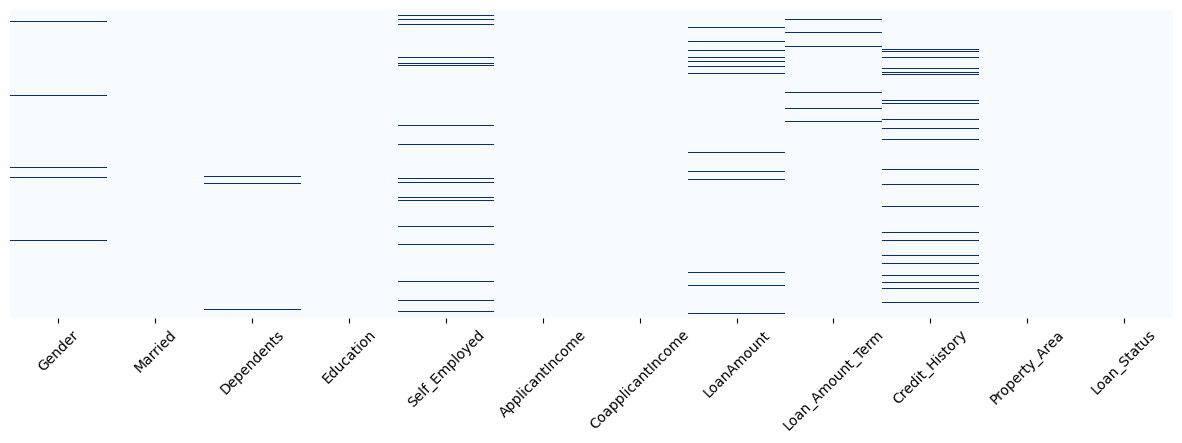

In [20]:
# Visualizing whether the missing values are missing at random or not
plt.figure(figsize=(15, 4))
sns.heatmap(df.isna(), cbar=False, cmap="Blues", yticklabels=False)
plt.xticks(rotation=45)
plt.show()

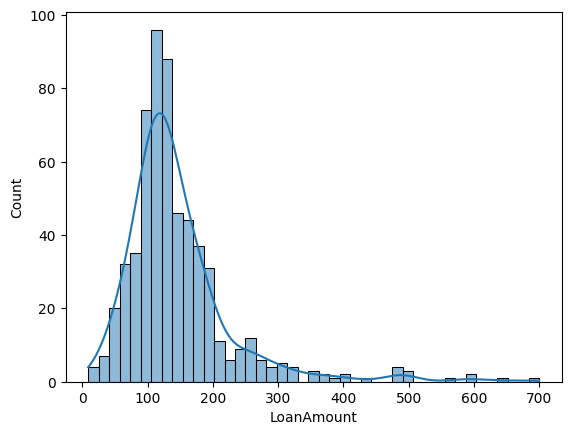

In [21]:
# Plotting histogram of numerical features that have missing values to decide whether to use mean or median
sns.histplot(df['LoanAmount'], kde=True)
plt.show()

Conclusions:

- Only one numerical feature (['LoanAmount']) has missing values.

- Six categorical features (['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']) have missing values.

- Since we only have few data points, we cannot afford to drop any data points.

- The percentage of missing values is low across all features, so there is no need to drop any columns.

- It appears that the missingness of values is random.

- Missing value handling:

    - Median imputation (for numerical features that are not normally distributed):
        - Loan amount

    - Mode imputation:
        - Categorical features


# Data Cleaning


Data cleaning conclusions:

- Outlier handling:

    - Since the outliers are valid, apply capping methods, such as:

        - Custom threshold capping: Set a threshold value based on analysis of the boxplots.
        - Percentile-based capping: Limit outliers to a specified percentile range.
        - Median imputation: Replace outliers with the median.


- Missing value handling:

    - Median imputation (for numerical features that are not normally distributed):
        - Loan amount

    - Mode imputation:
        - Categorical features

- Data type adjustments:

    - Data type comapatibility:
        - Applicant income: float
        - Loan_Amount_Term: int then, str
        - Credit_History: int then, str

    - Memory usage optimization:
        - Categorical features: category
        - Numerical features: float64 -> float32

In [22]:
# Outlier handling: Custom threshold capping

# Define the cap value
cap_values = [20833, 8980, 500]

for i, feature in enumerate(ftrs_with_outliers):
    # Cap the values
    df[feature] = df[feature].clip(upper=cap_values[i])

In [23]:
# Missing value handling

# Imputing missing values in LoanAmount feature with median
median_imputer = SimpleImputer(strategy='median')
df['LoanAmount'] = median_imputer.fit_transform(df[['LoanAmount']])

# Imputing missing values in categorical features with mode
mode_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols_with_na] = mode_imputer.fit_transform(df[cat_cols_with_na])

# Test
if df.isna().sum().sum() == 0:
    print("There are no missing values left in the DataFrame.")
else:
    print("There are still missing values in the DataFrame.")

There are no missing values left in the DataFrame.


In [24]:
# Checking memory usage before dtype adjustments
print("Memory usage before adjustment:", df.memory_usage(deep=True).sum())
print()

# Data type adjustments

# Data type compatibility
df['ApplicantIncome'] = df['ApplicantIncome'].astype(float)

# Converting numerical categorical features to int
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)

# Converting numerical categorical features to str
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(str)
df['Credit_History'] = df['Credit_History'].astype(str)

# Memory usage optimization
df[cat_cols] = df[cat_cols].astype('category')
df[num_cols] = df[num_cols].astype(np.float32)

# Print data types to confirm changes
print(df.dtypes)

# Checking memory usage after dtype adjustments
print()
print("Memory usage after adjustment:", df.memory_usage(deep=True).sum())

Memory usage before adjustment: 315494

Gender               category
Married              category
Dependents           category
Education            category
Self_Employed        category
ApplicantIncome       float32
CoapplicantIncome     float32
LoanAmount            float32
Loan_Amount_Term     category
Credit_History       category
Property_Area        category
Loan_Status            object
dtype: object

Memory usage after adjustment: 50771



# EDA (After data cleaning)



## Univariate analysis



### Numerical features


In [ ]:
df[num_cols].describe().T

In [ ]:
# Skewness and Kurtosis
skew_kurt_dict = {}
for col in num_cols:
    skew_kurt_dict[col] = {
        'skewness': round(float(df[col].skew()), 2),
        'kurtosis': round(float(df[col].kurtosis()), 2)
    }

print(json.dumps(skew_kurt_dict, indent=4))

In [ ]:
# Histogram & Box-plot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 10))

# Plotting histograms and boxplots
for i, col in enumerate(num_cols):
    # Histogram
    sns.histplot(df[col], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Boxplot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

Conclusions:

- Applicant income and loan amount approximately follow a log-normal distribution.
- Feature transformation is needed for all numerical features.
- It appears that individuals with a co-applicant income of 0 do not have a co-applicant. Therefore, create a feature named 'Has_coapplicant'. In this feature, set individuals with a co-applicant income of 0 to 'No, and those with a non-zero co-applicant income to 'Yes.


### Categorical features


In [ ]:
# Statistical measures
df[cat_cols].describe().T

In [ ]:
# Countplot

# Calculate number of rows and columns needed for subplots
n_cols = 3
n_rows = math.ceil(n_cat_cols / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten axs array if it's multidimensional
axs = axs.flatten()

# Plot countplots and set titles
for i, feature in enumerate(cat_cols):
    sns.countplot(data=df, x=feature, ax=axs[i])
    axs[i].set_title(feature)
    axs[i].tick_params(axis='x', rotation=45)

# Turn off any unused subplots
for j in range(len(cat_cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Conclusions:

- Males take out more loans compared to females.
- Married individuals take out more loans compared to - unmarried individuals.
- People without dependents take out more loans compared to those with dependents.
- Graduates take out more loans compared to non-graduates.
- Non-self-employed individuals take out more loans compared to self-employed individuals.
- Most people opt for a loan term of 360 months (30 years), followed by 180 months (15 years).
- People with a credit history of 1 take out more loans compared to those with a credit history of 0.
- People living in semi-urban areas take out more loans compared to those living in rural and urban areas. Rural residents take out the fewest loans. Although these relationships aren't strong, they may represent general trends.


## Bivariate analysis



### Between independent features



#### Numerical - Numerical


In [ ]:
# Pairplot
sns.pairplot(df[num_cols], diag_kind='kde')
plt.show()

In [ ]:
# regplot with PairGrid
graph = sns.PairGrid(df)

# type of graph for diagonal
graph = graph.map_diag(sns.histplot, kde=True)

# type of graph for non-diagonal
graph = graph.map_offdiag(sns.regplot, scatter=True, line_kws={'color': 'red'})

plt.show()

In [ ]:
# Creating a custom colorbar
# Define custom colors
colors = ["#FF0000", "#FFFF00", "#00FF00"]  # Red to Yellow to Green

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

In [ ]:
# Function to create a mask for the upper triangle
def create_mask(df, method):
    corr = df.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)  # Optional: keep or remove diagonal elements
    return mask

# Function to plot heatmap
def plot_heatmap(df, method, ax, cmap, title):
    mask = create_mask(df, method)
    sns.heatmap(df.corr(method=method), mask=mask, annot=True, cmap=cmap, ax=ax, cbar=False)
    ax.set_title(title)

In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# Plot Pearson and Spearman heatmaps
plot_heatmap(df[num_cols], 'pearson', axs[0], custom_cmap, 'Pearson Correlation Heatmap')
plot_heatmap(df[num_cols], 'spearman', axs[1], custom_cmap, 'Spearman Correlation Heatmap')

# Create a common colorbar for both heatmaps
cbar = fig.colorbar(axs[0].collections[0], cax=axs[2])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Conclusions:

- None of the features show a strong linear relationship with each other. However, there is a moderate relationship between applicant income and loan amount. This makes sense because individuals with higher incomes often need larger loan amounts.

- Both Pearson and Spearman correlation coefficients show similar patterns, but their values are slightly different. Since the heatmaps from both are similar, the exact values are less important. In this case, Spearman's correlation is more suitable because the data isn't normally distributed, doesn't have a linear relationship between features, and has outliers.


#### Categorical - Categorical


In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols * (n_cat_cols - 1) // 2, 2, figsize=(13, 140))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
plot_index = 0
for i in range(n_cat_cols):
    for j in range(i + 1, n_cat_cols):
        # Create contingency tables
        contingency_table_1 = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]], normalize='index') * 100
        contingency_table_2 = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]], normalize='columns') * 100

        # Plot heatmaps
        sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                    xticklabels=True, yticklabels=True, ax=axs[plot_index, 0])
        sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                    xticklabels=True, yticklabels=True, ax=axs[plot_index, 1])

        # Set titles for each subplot
        axs[plot_index, 0].set_title(f"{cat_cols[i]} vs {cat_cols[j]} (Index Normalized)")
        axs[plot_index, 1].set_title(f"{cat_cols[i]} vs {cat_cols[j]} (Column Normalized)")

        plot_index += 1

# Adjust layout
plt.tight_layout()
plt.show()


#### Numerical - Categorical


In [ ]:
# Applicant income
num_col = 'ApplicantIncome'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Coapplicant income
num_col = 'CoapplicantIncome'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Loan amount
num_col = 'LoanAmount'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()


### Between independent features and target feature



#### Categorical - Categorical

In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(13, 40))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
for i in range(n_cat_cols):
    # Create contingency tables
    contingency_table_1 = pd.crosstab(df[cat_cols[i]], df['Loan_Status'], normalize='index') * 100
    contingency_table_2 = pd.crosstab(df[cat_cols[i]], df['Loan_Status'], normalize='columns') * 100

    # Plot heatmaps
    sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 0])
    sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 1])

    # Set titles for each subplot
    axs[i, 0].set_title(f"{cat_cols[i]} vs Loan_Status (Index Normalized)")
    axs[i, 1].set_title(f"{cat_cols[i]} vs Loan_Status (Column Normalized)")

# Adjust layout
plt.tight_layout()
plt.show()


#### Numerical - Categorical


In [ ]:
# Violinplot & Pointplot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 9))

for i in range(n_num_cols):

    # Plot violinplot
    sns.violinplot(data=df, x='Loan_Status', y=num_cols[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_cols[i]} by Loan_Status')

    # Plot pointplot
    sns.pointplot(data=df, x='Loan_Status', y=num_cols[i], errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x='Loan_Status', y=num_cols[i], errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_cols[i]} by Loan_Status')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()


# Feature engineering



## Feature transformation


## Feature construction


- It appears that individuals with a co-applicant income of 0 do not have a co-applicant. Therefore, create a feature named 'Has_coapplicant'. In this feature, set individuals with a co-applicant income of 0 to 'No, and those with a non-zero co-applicant income to 'Yes.

In [25]:
df['Has_coapplicant'] = np.where(df['CoapplicantIncome'] == 0, 'No', 'Yes')
df['Has_coapplicant']

,Has_coapplicant
0,No
1,Yes
2,No
3,Yes
4,No
...,...
609,No
610,No
611,Yes
612,No


In [26]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Has_coapplicant
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360,1,Urban,Y,No
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360,1,Rural,N,Yes
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360,1,Urban,Y,No
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360,1,Urban,Y,Yes
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360,1,Urban,Y,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900.0,0.0,71.0,360,1,Rural,Y,No
610,Male,Yes,3+,Graduate,No,4106.0,0.0,40.0,180,1,Rural,Y,No
611,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360,1,Urban,Y,Yes
612,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360,1,Urban,Y,No



# EDA (On the basis of newly constructed features)



## Univariate analysis


In [ ]:
df['Has_coapplicant'].describe().T

In [ ]:
sns.countplot(x = df['Has_coapplicant'])
plt.show()


## Bivariate analysis



### Between independent features and newly constructed features



#### Categorical - Categorical

In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(13, 40))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
for i in range(n_cat_cols):
    # Create contingency tables
    contingency_table_1 = pd.crosstab(df[cat_cols[i]], df['Has_coapplicant'], normalize='index') * 100
    contingency_table_2 = pd.crosstab(df[cat_cols[i]], df['Has_coapplicant'], normalize='columns') * 100

    # Plot heatmaps
    sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 0])
    sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 1])

    # Set titles for each subplot
    axs[i, 0].set_title(f"{cat_cols[i]} vs Has_coapplicant (Index Normalized)")
    axs[i, 1].set_title(f"{cat_cols[i]} vs Has_coapplicant (Column Normalized)")

# Adjust layout
plt.tight_layout()
plt.show()


#### Numerical - Categorical


In [ ]:
# Violinplot & Pointplot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 9))

for i in range(n_num_cols):

    # Plot violinplot
    sns.violinplot(data=df, x='Has_coapplicant', y=num_cols[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_cols[i]} by Has_coapplicant')

    # Plot pointplot
    sns.pointplot(data=df, x='Has_coapplicant', y=num_cols[i], errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x='Has_coapplicant', y=num_cols[i], errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_cols[i]} by Has_coapplicant')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()


### Between newly constructed features and target feature


In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
for i in range(1):
    # Create contingency tables
    contingency_table_1 = pd.crosstab(df['Has_coapplicant'], df['Loan_Status'], normalize='index') * 100
    contingency_table_2 = pd.crosstab(df['Has_coapplicant'], df['Loan_Status'], normalize='columns') * 100

    # Plot heatmaps
    sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 0])
    sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 1])

    # Set titles for each subplot
    axs[i, 0].set_title(f"Has_coapplicant vs Loan_Status (Index Normalized)")
    axs[i, 1].set_title(f"Has_coapplicant vs Loan_Status (Column Normalized)")

# Adjust layout
plt.tight_layout()
plt.show()


# Building predictive model


## Preparing the data


In [27]:
# Appending newly constructed features to feature lists based on their type
cat_cols.append('Has_coapplicant')

In [28]:
# Splitting the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(df.drop('Loan_Status', axis=1),
                                                    df['Loan_Status'], test_size=0.2,
                                                    random_state=42)

In [29]:
# One hot encode categorical features of train data

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the training data
X_train_cat_encoded = ohe.fit_transform(X_train[cat_cols])
X_train_cat_encoded

array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])

In [ ]:
X_train[cat_cols]

In [ ]:
# Scale numerical features of the train data

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the train data
X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_train_num_scaled

In [ ]:
# Concatenating categorical encoded categorical features and scaled numerical features to a single numpy array
X_train_encoded_and_scaled = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_train_encoded_and_scaled

In [ ]:
# Label encode the target feature in train data

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the target feature
y_train = le.fit_transform(y_train)
y_train

In [ ]:
# One hot encode categorical features in test data
X_test_cat_encoded = ohe.transform(X_test[cat_cols])

# Scale numerical features in test data using standardization
X_test_num_scaled = scaler.transform(X_test[num_cols])

# Concatenate encoded and scaled data
X_test_encoded_and_scaled = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)
X_test_encoded_and_scaled

In [ ]:
# Label encode target feature of test data
y_test = le.transform(y_test)


## Model selection (Before hyperparameter tuning)


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Trees': DecisionTreeClassifier(),
    'Xgboost': XGBClassifier(),
    'Extra Trees': ExtraTreesClassifier()
}

# Define metrics
scoring_metrics = {
    'accuracy_score': make_scorer(accuracy_score),
    'precision_score': make_scorer(precision_score, average='macro'),
    'recall_score': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

In [ ]:
def evaluate_models(models, scoring_metrics, X_train, y_train):
    metrics_across_models = {model_name: {} for model_name in models.keys()}
    models_across_metrics = {metric_name: {} for metric_name in scoring_metrics.keys()}

    for model_name, model in models.items():
        for metric_name, scorer in scoring_metrics.items():
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
            cv_scores_mean = cv_scores.mean()

            metrics_across_models[model_name][metric_name] = round(cv_scores_mean, 3)
            models_across_metrics[metric_name][model_name] = round(cv_scores_mean, 3)

    sorted_models_across_metrics = {
        metric_name: dict(sorted(model_scores.items(), key=lambda item: item[1], reverse=True))
        for metric_name, model_scores in models_across_metrics.items()
    }

    return metrics_across_models, sorted_models_across_metrics

In [ ]:
metrics_across_models, sorted_models_across_metrics = evaluate_models(
    models, scoring_metrics, X_train_encoded_and_scaled, y_train
)

In [ ]:
# Comparing metrics across models
print(json.dumps(metrics_across_models, indent=4))

In [ ]:
# Comparing models across metrics
print(json.dumps(sorted_models_across_metrics, indent=4))

Conclusions:

After evaluating the metrics, I have decided to focus on the top 4 models: Logistic Regression, Random Forest Classifier, Support Vector Classifier (SVC), and Extra Trees Classifier. These models have demonstrated strong performance across the different metrics, making them the best candidates for further fine-tuning and optimization.


## Hyperparameter tuning


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Extra Trees': ExtraTreesClassifier()
}

In [ ]:
# Define parameter grids for models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Extra Trees': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
}

In [ ]:
def perform_grid_search(models, param_grids, X_train, y_train):
    best_params = {}
    for model_name, model in models.items():
        print(f"Processing {model_name}...")
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params[model_name] = {
            'Best Parameters': grid_search.best_params_,
            'Best Score': round(grid_search.best_score_, 3)
        }
    return best_params

In [ ]:
best_params = perform_grid_search(models, param_grids, X_train_encoded_and_scaled, y_train)

# Print best results from grid search
print(json.dumps(best_params, indent=4))

In [ ]:
# Initialize models for final evaluation
models_for_final_evaluation = {
    'Logistic Regression': LogisticRegression,
    'Random Forest': RandomForestClassifier,
    'Support Vector Machine': SVC,
    'Extra Trees': ExtraTreesClassifier
}

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

In [ ]:
def evaluate_best_models(best_params, models, X_train, X_test, y_train, y_test, metrics):
    results = {model_name: {metric_name: 0 for metric_name in metrics.keys()} for model_name in best_params.keys()}

    for model_name, best_params in best_params.items():
        model_cls = models[model_name]
        model = model_cls(**best_params['Best Parameters'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for metric_name, metric in metrics.items():
            results[model_name][metric_name] = metric(y_test, y_pred)

    return results

results = evaluate_best_models(
    best_params, models_for_final_evaluation, X_train_encoded_and_scaled,
    X_test_encoded_and_scaled, y_train, y_test, metrics
    )

# Print final model accuracies
print(json.dumps(results, indent=4))

In [ ]:
log_reg_clf = LogisticRegression(**best_params['Logistic Regression']['Best Parameters'])
log_reg_clf.fit(X_train_encoded_and_scaled, y_train)

In [ ]:
# from sklearn.ensemble import VotingClassifier

# # Initialize base models
# log_reg = LogisticRegression(**best_params['Logistic Regression']['Best Parameters'])
# rf = RandomForestClassifier(**best_params['Random Forest']['Best Parameters'])
# svc = SVC(**best_params['Support Vector Machine']['Best Parameters'])
# et = ExtraTreesClassifier(**best_params['Extra Trees']['Best Parameters'])

# # Create a Voting Classifier
# voting_clf = VotingClassifier(
#     estimators=[
#         ('log_reg', log_reg),
#         ('rf', rf),
#         ('svc', svc),
#         ('et', et)
#     ],
#     voting='hard'  # Use 'soft' for probability averaging or 'hard' for majority voting
# )

# # Train and evaluate the Voting Classifier
# def evaluate_ensemble(X_train, X_test, y_train, y_test, models, metrics):
#     results = {}
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         results[name] = {metric_name: metric(y_test, y_pred) for metric_name, metric in metrics.items()}
#     return results

# # Example usage of the function
# ensemble_results = evaluate_ensemble(
#     X_train_encoded_and_scaled, X_test_encoded_and_scaled, y_train, y_test,
#     {'Voting Classifier': voting_clf}, metrics
# )

# # Print ensemble results
# print(json.dumps(ensemble_results, indent=4))

## Saving

In [ ]:
# Save the model
with open("model.pkl", "wb") as f:
    pkl.dump(log_reg_clf, f)

In [ ]:
# Save standard scaler
with open('scaler.pkl', 'wb') as f:
    pkl.dump(scaler, f)

In [ ]:
# Save OHE
with open('encoder.pkl', 'wb') as f:
    pkl.dump(ohe, f)